In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kasikrit/att-database-of-faces
! unzip att-database-of-faces.zip -d ORL_Faces
! kaggle datasets download prasunroy/natural-images
! unzip natural-images.zip -d natural_images
dataset2_dir = "natural_images"

Streaming output truncated to the last 5000 lines.
  inflating: natural_images/natural_images/cat/cat_0204.jpg  
  inflating: natural_images/natural_images/cat/cat_0205.jpg  
  inflating: natural_images/natural_images/cat/cat_0206.jpg  
  inflating: natural_images/natural_images/cat/cat_0207.jpg  
  inflating: natural_images/natural_images/cat/cat_0208.jpg  
  inflating: natural_images/natural_images/cat/cat_0209.jpg  
  inflating: natural_images/natural_images/cat/cat_0210.jpg  
  inflating: natural_images/natural_images/cat/cat_0211.jpg  
  inflating: natural_images/natural_images/cat/cat_0212.jpg  
  inflating: natural_images/natural_images/cat/cat_0213.jpg  
  inflating: natural_images/natural_images/cat/cat_0214.jpg  
  inflating: natural_images/natural_images/cat/cat_0215.jpg  
  inflating: natural_images/natural_images/cat/cat_0216.jpg  
  inflating: natural_images/natural_images/cat/cat_0217.jpg  
  inflating: natural_images/natural_images/cat/cat_0218.jpg  
  inflating: natura

In [ ]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import metrics

In [ ]:
dataset_dir = "ORL_Faces"
y = []
D = []

def img_to_vector(filename):
    img  = Image.open(filename).resize((112, 92)) 
    img_vector = np.array(img).flatten()
    return img_vector


for i in range(40):
  person_id = i+1
  for j in range(10):
    path = dataset_dir + '/s'+str(person_id)+'/'+str(j+1)+'.pgm'
    row = img_to_vector(path).astype(np.int64) 
    D.append(row)
    y.append(person_id)
y = np.asarray(y)
D = np.asarray(D)

print(D.shape)

(400, 10304)


# function to load non image data with custom size

In [ ]:
import os
labels = ['airplane' ,'car', 'dog' ,'flower' , 'fruit' , 'motorbike']
rootdir = "natural_images/natural_images/"
def loadNonFaceData(size):
      
    catSize = size/6
    trainX = []
    trainY =[]

    for label in labels :
      for subdir, dirs, files in os.walk(os.path.join(rootdir+label)):
          i=0
          for file in files:
              i+=1
              if i> catSize:
                break
              img  = Image.open(os.path.join(rootdir+label,file)).convert('L').resize((112, 92))
              img = np.array(img).flatten()
              trainX.append(img)
              trainY.append(0)
    return np.asarray(trainX) , np.asarray(trainY)

# trainX = np.asarray(trainX)
# trainY = np.asarray(trainY)


# function to combine the two datasets

In [ ]:
from sklearn.model_selection import train_test_split

def combineData (D ,trainX, trainY ):

    d1_trainX, d1_testX, d1_trainY, d1_testY = train_test_split( D, np.ones(400), test_size=0.5, random_state=42)
    d2_trainX, d2_testX, d2_trainY, d2_testY = train_test_split( trainX, trainY, test_size=0.5, random_state=42)

    #print(trainX.shape , D.shape)
    trainX =  np.concatenate((d1_trainX, d2_trainX))
    trainY = np.concatenate((d1_trainY , d2_trainY))
    testX =  np.concatenate((d1_testX,d2_testX ))
    testY = np.concatenate((d1_testY , d2_testY ))

    trainX, trainY = shuffle(trainX, trainY)
    testX, testY = shuffle(testX, testY)
    return trainX, trainY ,  testX, testY



In [ ]:
def showFalsePred (y_pred , testY ,testX) :    ##  will be used to see the false predicted images
  for (i ,label) in enumerate(y_pred):
      if testY[i] != y_pred[i]:
        print( testY[i] , y_pred[i])
        imagew = testX[i].reshape((-1,112))
        plt.imshow(imagew)
        if label==0:
          plt.title("false prediction , prediction: non face")
        else:
          plt.title("false prediction , prediction:  face")
        plt.show()
        print(label)
        
def showTruePred (y_pred , testY ,testX) :   ##  will be used to see the true predicted images
  for (i ,label) in enumerate(y_pred):
    if testY[i] == y_pred[i]:
      imagew = testX[i].reshape((-1,112))
      plt.imshow(imagew)
      if label==0:
        plt.title("true prediction , prediction: non face")
      else:
        plt.title("true prediction , prediction:  face")
      plt.show()
      print(label)

#PCA

In [ ]:
class PCA:
    def __init__(self,alpha):
        self.n_components = 0
        self.components = None
        self.mean = None
        self.alpha =alpha

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        cov = np.cov(X.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        r = 0
        while ( (np.sum(eigenvalues[0:r]) / np.sum(eigenvalues)) - self.alpha <= 1e-14):
          r+= 1
          
        self.n_components = r
        # store first n eigenvectors
        self.components = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)
  



In [ ]:
trainX , trainY = loadNonFaceData(400)
trainX, trainY, testX, testY = combineData(D,trainX, trainY)

pca = PCA(0.8)
pca.fit(trainX)
X_train_projected = pca.transform(trainX)
X_test_projected = pca.transform(testX)



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knnc = KNeighborsClassifier(n_neighbors=1)
knnc.fit(np.real(X_train_projected),np.real(trainY))
y_pred = knnc.predict(np.real(X_test_projected))
metrics.accuracy_score(testY,y_pred)

In [ ]:
###  run it to use random forest instead

# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators = 1000)
# rf.fit(np.real(X_train_projected),np.real(trainY))
# y_pred = rf.predict(np.real(X_test_projected))
# metrics.accuracy_score(testY,y_pred)

# PCA classifier prediction results


False predictions

In [ ]:
showFalsePred (y_pred , testY ,testX)

True predictions

In [ ]:
showTruePred(y_pred , testY ,testX) 

#LDA Classifier

In [ ]:
class LDA:
    def __init__(self):
      return


    def fit(self, d_train ,y_train):
        
        mean_vector = np.mean(d_train, axis=0)
        x,n=np.unique(y_train,return_counts=True)
        mean_vector_class=np.zeros((len(n),d_train.shape[1]))
        data_centered_classes=np.zeros((d_train.shape[0],d_train.shape[1]))

        S_t=np.zeros((d_train.shape[1],d_train.shape[1]))
        B=np.zeros((d_train.shape[1],d_train.shape[1]))

        for i in range (len(n)):
            mean_vector_class[i]=np.mean(d_train[np.sum(n[0:i]):np.sum(n[0:i+1])],axis=0)
            B=B+n[i]*np.matmul((mean_vector_class[i]-mean_vector).T,(mean_vector_class[i]-mean_vector))
            data_centered_classes[np.sum(n[0:i]):np.sum(n[0:i+1])]=d_train[np.sum(n[0:i]):np.sum(n[0:i+1])]-mean_vector_class[i]
            S=np.matmul((data_centered_classes[np.sum(n[0:i]):np.sum(n[0:i+1])]).T,data_centered_classes[np.sum(n[0:i]):np.sum(n[0:i+1])])
            S_t=S_t+S

        #compute dominant eigenvector
        eigen_values, U = np.linalg.eigh(np.dot(np.linalg.inv(S_t),B))
        index = np.argsort(eigen_values)[::-1]
        sorted_eigenvectors = U[:,index]
        self.eigenvectors=sorted_eigenvectors

    def transform(self, X ,  no_components):
        # project data
        eigenvectors=self.eigenvectors[:,0:no_components]
        return (np.matmul(eigenvectors.T, X.T)).T
  


##selecting the best no of components

In [ ]:
#from sklearn.ensemble import RandomForestClassifier
trainX , trainY = loadNonFaceData(400)
trainX, trainY, testX, testY = combineData(D,trainX, trainY)

from sklearn.neighbors import KNeighborsClassifier

lda = LDA()
lda.fit(trainX,trainY)

no_c = np.linspace(1,10304,num=10304)
maxAcc = 0
max_c =1
for n in no_c:   
  n = int(n)

  X_train_projected = lda.transform(trainX ,n)
  X_test_projected = lda.transform(testX, n)  
  # rf = RandomForestClassifier(n_estimators = 1000)
  # rf.fit(np.real(X_train_projected),np.real(trainY))
  # y_pred = rf.predict(np.real(X_test_projected))

  knnc = KNeighborsClassifier(n_neighbors=1)
  knnc.fit(np.real(X_train_projected),np.real(trainY))
  y_pred = knnc.predict(np.real(X_test_projected))

  acc = metrics.accuracy_score(testY,y_pred)
  print(n , acc)
  if acc>maxAcc :
    max_c = n
    maxAcc = acc




# testing with the best no of components

In [ ]:
  X_train_projected = lda.transform(trainX ,171 )
  X_test_projected = lda.transform(testX, 171 )  
  knnc = KNeighborsClassifier(n_neighbors=2)
  knnc.fit(np.real(X_train_projected),np.real(trainY))
  y_pred = knnc.predict(np.real(X_test_projected))

In [ ]:
###  run it to use random forest instead

# from sklearn.ensemble import RandomForestClassifier
# X_train_projected = lda.transform(trainX ,79  )
# X_test_projected = lda.transform(testX, 79  )  
# rf = RandomForestClassifier(n_estimators = 1000)
# rf.fit(np.real(X_train_projected),np.real(trainY))
# y_pred = rf.predict(np.real(X_test_projected))

1.0 0.0


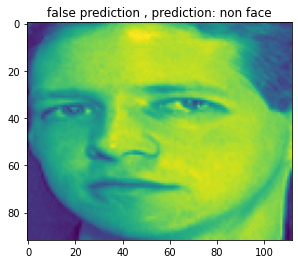

0.0
1.0 0.0


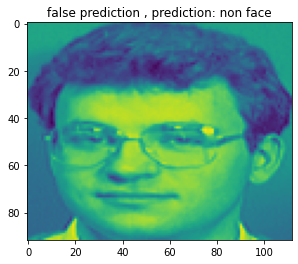

0.0
0.0 1.0


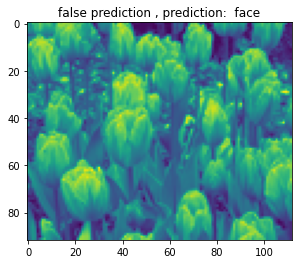

1.0
0.0 1.0


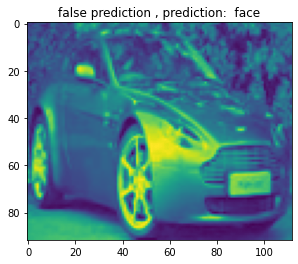

1.0
0.0 1.0


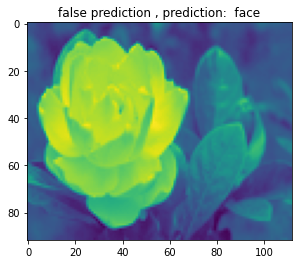

1.0
1.0 0.0


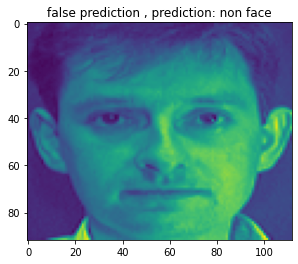

0.0
1.0 0.0


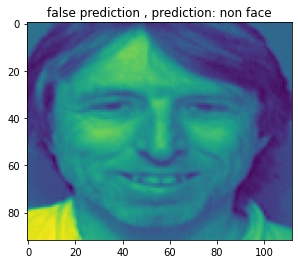

0.0
0.0 1.0


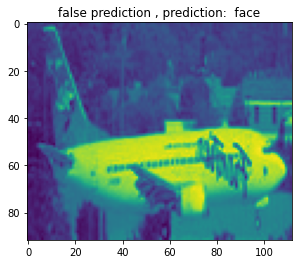

1.0
1.0 0.0


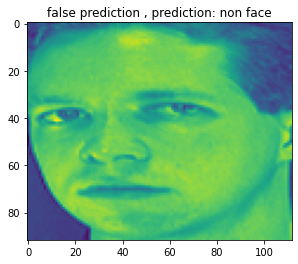

0.0
0.0 1.0


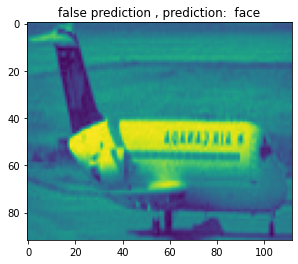

1.0
0.0 1.0


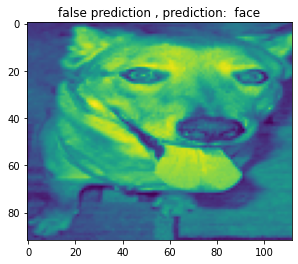

1.0
1.0 0.0


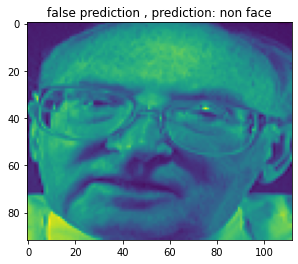

0.0
1.0 0.0


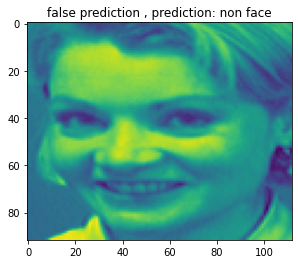

0.0
1.0 0.0


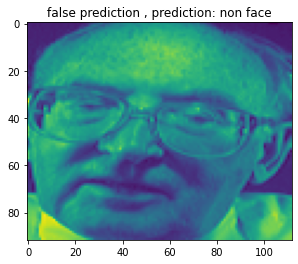

0.0
0.0 1.0


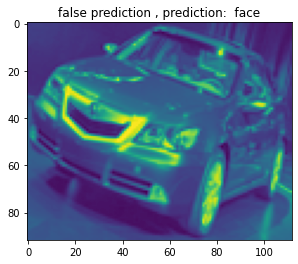

1.0
1.0 0.0


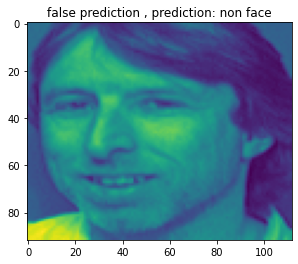

0.0
0.0 1.0


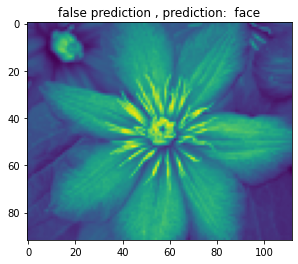

1.0
1.0 0.0


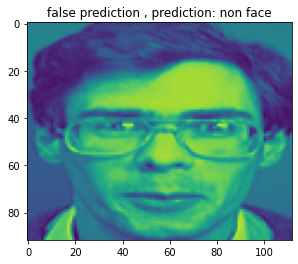

0.0
0.0 1.0


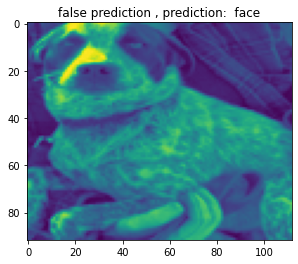

1.0


In [ ]:
showFalsePred(y_pred , testY ,testX)


In [ ]:
showTruePred(y_pred , testY ,testX)

#size of Non-faces analysis (PCA)

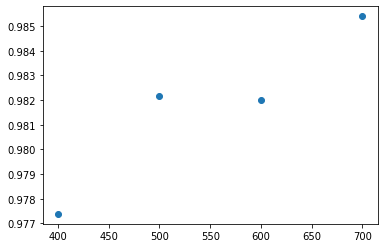

In [ ]:
from sklearn.ensemble import RandomForestClassifier

sizes = [400, 500, 600 ,700 , 900 , 1000 , 1500 , 3000]
accs =[]

for size in sizes:
   trainX , trainY = loadNonFaceData(size)
   trainX, trainY, testX, testY = combineData(D,trainX, trainY)
   pca = PCA(0.8)
   pca.fit(trainX)
   X_train_projected = pca.transform(trainX)
   X_test_projected = pca.transform(testX)
   rf = RandomForestClassifier(n_estimators = 1000)
   rf.fit(np.real(X_train_projected),np.real(trainY))
   y_pred = rf.predict(np.real(X_test_projected))
   acc= metrics.accuracy_score(testY,y_pred)
   accs.append(acc)

plt.scatter( sizes , accs )
plt.show()



#size of Non-faces analysis (LDA)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

sizes = [400, 500, 600 ,700 , 900 , 1000 , 1500 , 3000]
accs =[]

for size in sizes:
   trainX , trainY = loadNonFaceData(size)
   trainX, trainY, testX, testY = combineData(D,trainX, trainY)
   lda = LDA(1)
   lda.fit(trainX)
   X_train_projected = lda.transform(trainX)
   X_test_projected = lda.transform(testX)
   rf = RandomForestClassifier(n_estimators = 1000)
   rf.fit(np.real(X_train_projected),np.real(trainY))
   y_pred = rf.predict(np.real(X_test_projected))
   acc= metrics.accuracy_score(testY,y_pred)
   accs.append(acc)

plt.scatter( sizes , accs )
plt.show()